# LangGraph Agent

## Pipeline

In [ ]:
%%capture
!pip install -U langchain langchain-openai yfinance langgraph ffmpeg-python

In [ ]:
#@markdown 取得錄音資訊
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
from IPython.display import Audio

def listenTo():
  audio, rate = get_audio()
  ad = Audio(audio, rate=rate)
  audio_file = '/content/test.wav'
  with open(audio_file, 'wb') as f:
      f.write(ad.data)
  audio_ = open(audio_file, "rb")
  transcript = client.audio.transcriptions.create(
    model="gpt-4o-mini-transcribe",
    file=audio_
  )
  return transcript.text

In [ ]:

def transcribe_audio(file_path):
    with open(file_path, "rb") as f:
        resp = model.audio.transcriptions.create(
            model="gpt-4o-mini-transcribe",  # 或 whisper 類型的 model
            file=f,
            # language="zh",  # 如果主要是中文可以指定
        )
    return resp.text

In [ ]:
import os
from openai import OpenAI
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from IPython.display import Audio
os.environ["OPENAI_API_KEY"] = "sk-proj-"

# 初始化 OpenAI client (for STT)
client = OpenAI()

# 初始化 LLM(用於回答問題)
llm = ChatOpenAI(
    model="gpt-4.1",
    temperature=0.7
)

# 你的 listenTo 函數
def listenTo():
    audio, rate = get_audio()
    ad = Audio(audio, rate=rate)
    audio_file = '/content/test.wav'
    with open(audio_file, 'wb') as f:
        f.write(ad.data)

    with open(audio_file, "rb") as audio_:
        transcript = client.audio.transcriptions.create(
            model="whisper-1",  # 使用穩定的 Whisper 模型
            file=audio_,
            language="zh"  # 指定中文提高準確度
        )
    return transcript.text

# 定義狀態結構
class SimpleState(TypedDict):
    audio_path: Optional[str]
    text: Optional[str]
    answer: Optional[str]
    use_recording: bool

# STT 節點
def stt_node(state: SimpleState) -> SimpleState:
    state["text"] = listenTo()
    return state

# 回答節點
def answer_node(state: SimpleState) -> SimpleState:
    user_text = state["text"]
    msgs = [
        {"role": "system", "content": "你是一位金融客服,用白話回答使用者問題。"},
        {"role": "user", "content": user_text},
    ]
    resp = llm.invoke(msgs)
    state["answer"] = resp.content
    return state

# 建立 Graph
graph = StateGraph(SimpleState)
graph.add_node("stt", stt_node)
graph.add_node("answer", answer_node)
graph.set_entry_point("stt")
graph.add_edge("stt", "answer")
graph.add_edge("answer", END)
app = graph.compile()

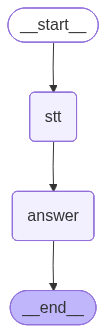

In [ ]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [ ]:
print(app.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	stt(stt)
	answer(answer)
	__end__([<p>__end__</p>]):::last
	__start__ --> stt;
	stt --> answer;
	answer --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [ ]:
print("請開始說話...")
init_state_recording: SimpleState = {
    "audio_path": None,
    "text": None,
    "answer": None,
    "use_recording": True  # 使用即時錄音
}
result = app.invoke(init_state_recording)
print("STT 結果:", result["text"])
print("回覆:", result["answer"])

請開始說話...


STT 結果: 你好 你好
回覆: 你好！請問有什麼金融相關的問題需要我幫忙解答嗎？


## 加入金融詞彙修正節點

In [ ]:
class StateWithNorm(TypedDict):
    audio_path: Optional[str]
    raw_text: Optional[str]           # STT 原始文字
    normalized_text: Optional[str]    # 金融詞修正後的文字
    answer: Optional[str]
    use_recording: bool

In [ ]:
FIN_TERMS = [
    "台積電", "鴻海", "聯發科", "中華電", "曾繁城",
    "0050", "0056", "00878", "006208",
    "除權息", "殖利率", "淨值", "ETF", "配息",
    "本益比", "股息", "漲停", "跌停", "融資", "融券"
]

def normalize_fin_terms(text: str) -> str:
    """使用 LLM 修正金融專有名詞"""
    prompt = (
        "你是一位金融文本校正助手。\n"
        "以下這段文字來自語音辨識，裡面可能有金融專有名詞被聽錯或打錯。\n"
        "請幫我修正成標準金融用語，但不要改變原本意思。\n"
        f"常見金融用語包含：{', '.join(FIN_TERMS)}。\n"
        "只輸出修正後的文字，不要多加解釋。\n\n"
        f"文字：{text}"
    )
    msgs = [{"role": "user", "content": prompt}]
    resp = llm.invoke(msgs)
    return resp.content

In [ ]:
# ==================== Node 1: STT 節點 ====================
def stt_node2(state: StateWithNorm) -> StateWithNorm:
    """語音轉文字節點"""
    state["raw_text"] = listenTo()
    return state

# ==================== Node 2: 金融詞彙修正節點 ====================
def normalize_node(state: StateWithNorm) -> StateWithNorm:
    """金融詞彙修正節點 - 這是針對金融語音痛點的關鍵節點"""
    norm = normalize_fin_terms(state["raw_text"] or "")
    state["normalized_text"] = norm
    return state

# ==================== Node 3: 回答節點 ====================
def answer_node2(state: StateWithNorm) -> StateWithNorm:
    """使用修正後的文字生成回答"""
    user_text = state["normalized_text"] or ""
    msgs = [
        {"role": "system", "content": "你是一位金融客服,用白話解釋,特別注意金融名詞要正確。"},
        {"role": "user", "content": user_text},
    ]
    resp = llm.invoke(msgs)
    state["answer"] = resp.content
    return state

In [ ]:
graph2 = StateGraph(StateWithNorm)

# 加入三個節點
graph2.add_node("stt", stt_node2)
graph2.add_node("normalize", normalize_node)  #金融詞修正節點
graph2.add_node("answer", answer_node2)

# 設定流程: STT → 金融詞修正 → 回答 → 結束
graph2.set_entry_point("stt")
graph2.add_edge("stt", "normalize")
graph2.add_edge("normalize", "answer")
graph2.add_edge("answer", END)

# 編譯
app2 = graph2.compile()

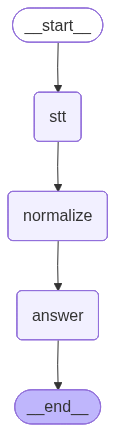

In [ ]:
from IPython.display import Image
Image(app2.get_graph().draw_mermaid_png())

In [ ]:
print("請開始說話...")
init_state_recording: StateWithNorm = {
    "audio_path": None,
    "raw_text": None,
    "normalized_text": None,
    "answer": None,
    "use_recording": True  # 使用即時錄音
}

result2 = app2.invoke(init_state_recording)
print("\n" + "="*60)
print("STT 原始文字:", result2["raw_text"])
print("="*60)
print("金融詞修正後:", result2["normalized_text"])
print("="*60)
print("AI 回覆:", result2["answer"])
print("="*60)


請開始說話...



STT 原始文字: 我要購買0050
金融詞修正後: 我要購買0050。
AI 回覆: 當然，我來幫你解釋！

你說的「0050」是指「元大台灣50ETF」，這是一檔在台灣證券交易所上市的「指數股票型基金」（英文叫做ETF, Exchange Traded Fund）。它追蹤的是「台灣50指數」，也就是台灣市值最大的前50間上市公司。

簡單來說，買0050就像是一次買進台灣前50大公司的股票組合。這樣做的好處是可以分散風險，不需要自己一檔一檔去買個股。

購買方式：

1. 開立證券戶：你需要先在銀行或券商開一個證券帳戶。
2. 下單購買：登入你的證券戶，輸入「0050」這個股票代號，選擇你要買的股數和價格，然後下單就可以了。
3. 交易時間：ETF跟一般股票一樣，只有在股市開盤時間（平日早上9點到下午1點半）可以買賣。

如果你有更多問題，或需要更詳細的操作流程，歡迎再問我！


## Orchestrator / Router Pattern

In [ ]:
# ==================== 定義 State ====================
class StateWithOrchestrator(TypedDict):
    audio_path: Optional[str]
    text: Optional[str]
    intent: Optional[str]
    stock_info: Optional[str]
    portfolio_info: Optional[str]
    general_info: Optional[str]
    answer: Optional[str]
    use_recording: bool

In [ ]:
import yfinance as yf
from typing import TypedDict, Optional, Literal
import json

# ==================== Orchestrator 節點 ====================
def orchestrator_node(state: StateWithOrchestrator) -> StateWithOrchestrator:
    """意圖分類節點 - 決定要走哪條路"""
    user_text = state["text"] or ""

    prompt = f"""你是一位意圖分類專家。請分析使用者的問題,判斷屬於以下哪一類:

    1. stock_price (即時股價查詢)
      - 範例:"台積電現在多少錢?"、"鴻海今天漲了嗎?"

    2. portfolio (個人庫存查詢)
      - 範例:"我的台積電還有多少股?"、"我持有的0050成本多少?"

    3. general_qa (一般金融知識)
      - 範例:"什麼是ETF?"、"除權息是什麼意思?"

    只回答 JSON 格式:{{"intent": "stock_price"}} 或 {{"intent": "portfolio"}} 或 {{"intent": "general_qa"}}

    使用者問題:{user_text}"""

    msgs = [{"role": "user", "content": prompt}]
    resp = llm.invoke(msgs)

    print(resp.content)
    # 解析 JSON
    result = json.loads(resp.content)
    intent = result.get("intent", "general_qa")

    state["intent"] = intent
    print(f"意圖判定: {intent}")
    return state

# ==================== 路由函數 ====================
def route_by_intent(state: StateWithOrchestrator) -> Literal["stock_query", "portfolio_query", "general_qa"]:
    """根據意圖決定下一個節點"""
    intent = state.get("intent", "general_qa")

    if intent == "stock_price":
        return "stock_query"
    elif intent == "portfolio":
        return "portfolio_query"
    else:
        return "general_qa"

In [ ]:

# ==================== 股價查詢節點 ====================
def stock_query_node(state: StateWithOrchestrator) -> StateWithOrchestrator:
    """查詢即時股價 - 使用 LLM 識別股票"""
    user_text = state["text"] or ""

    # 步驟 1: 用 LLM 找出股票名稱和代碼
    prompt = f"""請從問題中找出股票名稱,並轉換為代碼。

常見股票對應:
- 台積電 → 2330.TW
- 鴻海 → 2317.TW
- 0050 → 0050.TW
- 0056 → 0056.TW

只回答 JSON: {{"stock_name": "台積電", "stock_code": "2330.TW"}}

使用者問題: {user_text}"""

    response = llm.invoke([{"role": "user", "content": prompt}])

    # 步驟 2: 解析 LLM 回應
    try:
        # 清理回應(移除可能的 markdown 標記)
        content = response.content.replace("```json", "").replace("```", "").strip()
        result = json.loads(content)

        stock_name = result["stock_name"]
        stock_code = result["stock_code"]

        print(f"識別到: {stock_name} ({stock_code})")

    except:
        state["stock_info"] = "無法識別股票"
        return state

    # 步驟 3: 用 yfinance 查詢股價
    try:
        ticker = yf.Ticker(stock_code)
        data = ticker.history(period='1d')

        # 取得今天的資料
        latest_price = data['Close'].iloc[-1]
        open_price = data['Open'].iloc[-1]
        change = latest_price - open_price
        change_percent = (change / open_price) * 100

        # 步驟 4: 格式化結果
        info_text = f"""{stock_name}({stock_code})
最新價: {latest_price:.2f} 元
今日漲跌: {change:+.2f} 元 ({change_percent:+.2f}%)"""

        state["stock_info"] = info_text
        print(f"查詢成功!\n{info_text}")

    except:
        state["stock_info"] = f"無法查詢 {stock_name} 的股價"

    return state

# ==================== 庫存查詢節點 ====================
def portfolio_query_node(state: StateWithOrchestrator) -> StateWithOrchestrator:
    """查詢個人持股"""
    user_text = state["text"] or ""

    # 提取股票名稱
    stock_name = None
    for name in USER_PORTFOLIO.keys():
        if name in user_text:
            stock_name = name
            break

    if not stock_name:
        state["portfolio_info"] = "無法識別您要查詢的股票"
        return state

    # 查詢持股資料
    portfolio = USER_PORTFOLIO[stock_name]
    shares = portfolio["shares"]
    avg_cost = portfolio["avg_cost"]
    total_cost = shares * avg_cost

    info_text = f"""您持有 {stock_name} {shares} 股
平均成本: {avg_cost} 元/股
總成本: {total_cost:,} 元"""

    # 進階: 查詢即時股價計算損益
    stock_code = STOCK_CODES.get(stock_name)
    if stock_code:
        try:
            ticker = yf.Ticker(stock_code)
            history = ticker.history(period='1d')
            if not history.empty:
                current_price = history['Close'].iloc[-1]
                current_value = shares * current_price
                profit = current_value - total_cost
                profit_pct = (profit / total_cost) * 100

                info_text += f"""
目前價格: {current_price:.2f} 元/股
目前市值: {current_value:,.0f} 元
損益: {profit:+,.0f} 元 ({profit_pct:+.2f}%)"""
        except:
            pass

    state["portfolio_info"] = info_text
    print(f"庫存資訊:\n{info_text}")
    return state

# ==================== 一般問答節點 ====================
def general_qa_node(state: StateWithOrchestrator) -> StateWithOrchestrator:
    """一般金融知識問答"""
    user_text = state["text"] or ""

    prompt = f"""你是一位金融專家,請用白話文解釋以下問題:
{user_text}

回答要求:
- 簡單易懂
- 適合一般投資人
- 200字以內"""

    msgs = [{"role": "user", "content": prompt}]
    resp = llm.invoke(msgs)

    state["general_info"] = resp.content
    print(f"知識回答:\n{resp.content}")
    return state

In [ ]:

# ==================== Answer 節點 ====================
def answer_node(state: StateWithOrchestrator) -> StateWithOrchestrator:
    """整合所有資訊生成最終回答"""
    user_text = state["text"] or ""

    # 組合 context
    context_parts = []

    if state.get("stock_info"):
        context_parts.append(f"【即時股價】\n{state['stock_info']}")

    if state.get("portfolio_info"):
        context_parts.append(f"【個人庫存】\n{state['portfolio_info']}")

    if state.get("general_info"):
        context_parts.append(f"【知識說明】\n{state['general_info']}")

    context = "\n\n".join(context_parts) if context_parts else "無額外資訊"

    prompt = f"""你是專業金融客服,請根據以下資訊回答使用者問題。

使用者問題: {user_text}

【可用資訊】
{context}

請用親切、專業的語氣回答,字數控制在 150 字以內。"""

    msgs = [{"role": "user", "content": prompt}]
    resp = llm.invoke(msgs)

    state["answer"] = resp.content
    return state

In [ ]:
# ==================== 股票代碼對應表 ====================
STOCK_CODES = {
    "台積電": "2330.TW",
    "鴻海": "2317.TW",
    "聯發科": "2454.TW",
    "中華電": "2412.TW",
    "0050": "0050.TW",
    "0056": "0056.TW",
    "00878": "00878.TW",
}

# ==================== 模擬個人持股資料 ====================
USER_PORTFOLIO = {
    "台積電": {
        "shares": 10,
        "avg_cost": 550,
    },
    "0050": {
        "shares": 50,
        "avg_cost": 130,
    },
    "鴻海": {
        "shares": 100,
        "avg_cost": 95,
    }
}

In [ ]:
# 跳過 STT,直接從 orchestrator 開始測試
graph_test = StateGraph(StateWithOrchestrator)
graph_test.add_node("orchestrator", orchestrator_node)
graph_test.add_node("stock_query", stock_query_node)
graph_test.add_node("portfolio_query", portfolio_query_node)
graph_test.add_node("general_qa", general_qa_node)
graph_test.add_node("answer", answer_node)
graph_test.set_entry_point("orchestrator")
graph_test.add_conditional_edges(
    "orchestrator",
    route_by_intent,
    {
        "stock_query": "stock_query",
        "portfolio_query": "portfolio_query",
        "general_qa": "general_qa"
    }
)
graph_test.add_edge("stock_query", "answer")
graph_test.add_edge("portfolio_query", "answer")
graph_test.add_edge("general_qa", "answer")
graph_test.add_edge("answer", END)
app_test = graph_test.compile()

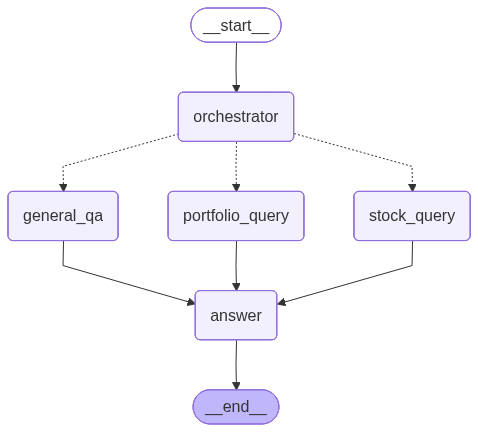

In [ ]:
Image(app_test.get_graph().draw_mermaid_png())

In [ ]:
test1: StateWithOrchestrator = {
    "audio_path": None,
    "text": "台積電現在股價多少?",
    "intent": None,
    "stock_info": None,
    "portfolio_info": None,
    "general_info": None,
    "answer": None,
    "use_recording": False
}

result1 = app_test.invoke(test1)
print(f"\n最終回答:\n{result1['answer']}")

print("\n" + "="*80)
print("測試 2: 庫存查詢")
print("="*80)
test2: StateWithOrchestrator = {
    "audio_path": None,
    "text": "我的台積電還有多少股?",
    "intent": None,
    "stock_info": None,
    "portfolio_info": None,
    "general_info": None,
    "answer": None,
    "use_recording": False
}
result2 = app_test.invoke(test2)
print(f"\n最終回答:\n{result2['answer']}")

print("\n" + "="*80)
print("測試 3: 一般問答")
print("="*80)
test3: StateWithOrchestrator = {
    "audio_path": None,
    "text": "什麼是ETF?",
    "intent": None,
    "stock_info": None,
    "portfolio_info": None,
    "general_info": None,
    "answer": None,
    "use_recording": False
}
result3 = app_test.invoke(test3)
print(f"\n最終回答:\n{result3['answer']}")


{"intent": "stock_price"}
意圖判定: stock_price
識別到: 台積電 (2330.TW)
📊 查詢成功!
台積電(2330.TW)
最新價: 1395.00 元
今日漲跌: -5.00 元 (-0.36%)

最終回答:
您好，感謝您的提問。根據最新資訊，台積電（2330.TW）目前的股價為 1,395.00 元，今日下跌 5.00 元，跌幅為 0.36%。若您需要進一步查詢歷史股價或其他相關資訊，歡迎隨時告知，我們很樂意為您提供協助。祝您投資順利！

測試 2: 庫存查詢
{"intent": "portfolio"}
意圖判定: portfolio
💼 庫存資訊:
您持有 台積電 10 股
平均成本: 550 元/股
總成本: 5,500 元
目前價格: 1395.00 元/股
目前市值: 13,950 元
損益: +8,450 元 (+153.64%)

最終回答:
您好，您目前持有台積電（2330）共 10 股。根據最新資訊，您的平均買進成本為每股 550 元，目前市價為每股 1,395 元，您的台積電持股市值為 13,950 元。若您有其他投資相關問題，歡迎隨時詢問，我們很樂意為您服務！

測試 3: 一般問答
{"intent": "general_qa"}
意圖判定: general_qa
📚 知識回答:
ETF的全名是「指數股票型基金」，簡單來說，就是一種可以在股票市場買賣的基金。ETF會追蹤一個特定的指數（比如台灣50、標普500），幫投資人把錢分散投資在很多公司，降低風險。你就像買一籃不同公司的股票，但只要買一張ETF就好了。ETF交易方式和股票一樣，可以隨時在市場上買賣，手續費也通常比較低。對一般投資人來說，ETF是一種方便、簡單又有效率的投資工具。

最終回答:
ETF，全名為「指數股票型基金」，是一種在股票市場上可以像股票一樣買賣的基金。ETF會追蹤特定指數（如台灣50、標普500），將您的資金分散投資於多家公司，有助於降低投資風險。購買ETF就像一次買進多家公司的股票，既方便又省時。ETF的交易方式靈活，手續費較低，非常適合希望簡單理財的投資人。如果您有更多問題，歡迎隨時詢問！

所有測試完成!


## Memory

In [ ]:
# ==================== 模擬記憶資料庫 ====================
MEM_DB = {
    "user-001": {
        "name": "王小明",
        "risk": "conservative",  # 保守型
        "favorites": ["0056", "00878"],
        "notes": ["不想承擔太大波動", "偏好穩定配息"]
    },
    "user-002": {
        "name": "李大華",
        "risk": "aggressive",  # 積極型
        "favorites": ["2330", "2454"],
        "notes": ["願意承擔高風險", "看好半導體產業"]
    },
    "user-003": {
        "name": "陳美玲",
        "risk": "moderate",  # 穩健型
        "favorites": ["0050", "2330"],
        "notes": ["平衡風險與報酬", "長期投資"]
    }
}


In [ ]:
from typing import TypedDict, Optional, Dict
# ==================== 定義 State ====================
class MemoryState(TypedDict):
    user_id: str
    text: str  # 使用者問題(文字)
    user_profile: Optional[Dict]  # 使用者檔案
    answer: Optional[str]  # AI 回答


In [ ]:

# ==================== Node 1: 載入記憶 ====================
def load_memory_node(state: MemoryState) -> MemoryState:
    """載入使用者記憶檔案"""
    user_id = state["user_id"]

    # 從資料庫載入使用者檔案
    profile = MEM_DB.get(user_id, {
        "name": "訪客",
        "risk": "unknown",
        "favorites": [],
        "notes": []
    })

    state["user_profile"] = profile

    print("="*60)
    print(f"   載入記憶: {profile['name']}")
    print(f"   風險屬性: {profile['risk']}")
    print(f"   偏好標的: {', '.join(profile['favorites'])}")
    print(f"   投資備註: {', '.join(profile['notes'])}")
    print("="*60)

    return state

# ==================== Node 2: 回答 (使用記憶!) ====================
def answer_with_memory_node(state: MemoryState) -> MemoryState:
    """根據使用者檔案生成個人化回答"""
    profile = state["user_profile"]
    user_text = state["text"]

    # 準備使用者資料摘要
    profile_summary = f"""姓名: {profile['name']}
風險屬性: {profile['risk']}
常關注標的: {', '.join(profile['favorites'])}
投資偏好: {', '.join(profile['notes'])}"""

    print(f"\n 使用者問題: {user_text}")
    print(f" 使用記憶回答...\n")

    # System Prompt - 告訴 LLM 使用者的投資屬性
    system_prompt = f"""你是專業金融客服,回答時要根據使用者的風險屬性給建議。

【使用者檔案】
{profile_summary}

重要規則:
- conservative (保守型): 推薦高股息 ETF、金融股、電信股,避免高波動股票
- aggressive (積極型): 可以推薦成長型科技股、新創產業、波動較大標的
- moderate (穩健型): 建議大盤 ETF 和穩健龍頭股,平衡配置

回答要親切、專業,考慮使用者的投資屬性,150字內。"""

    msgs = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_text}
    ]

    response = llm.invoke(msgs)
    state["answer"] = response.content

    return state

# ==================== Node 3: 儲存記憶 ====================
def save_memory_node(state: MemoryState) -> MemoryState:
    """記錄這次互動到資料庫"""
    user_id = state["user_id"]
    user_text = state["text"]

    print(f"\n儲存記憶: 記錄 {MEM_DB[user_id]['name']} 的互動")

    # 簡單記錄:檢查使用者提到哪些標的
    if user_id in MEM_DB:
        stocks = ["2330", "0050", "0056", "00878", "台積電", "鴻海", "聯發科"]
        mentioned = [s for s in stocks if s in user_text]

        if mentioned:
            print(f"   記錄關注標的: {', '.join(mentioned)}")
            # 實際應用中會寫入資料庫

    return state

In [ ]:

# ==================== 建立 Graph ====================
graph = StateGraph(MemoryState)

# 三個簡單節點
graph.add_node("load_memory", load_memory_node)   # 1. 載入記憶
graph.add_node("answer", answer_with_memory_node)  # 2. 用記憶回答
graph.add_node("save_memory", save_memory_node)    # 3. 儲存記憶

# 線性流程
graph.set_entry_point("load_memory")
graph.add_edge("load_memory", "answer")
graph.add_edge("answer", "save_memory")
graph.add_edge("save_memory", END)

# 編譯
app = graph.compile()

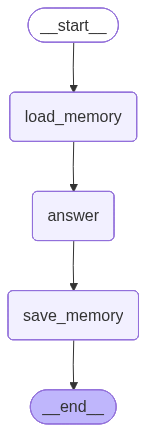

In [ ]:
Image(app.get_graph().draw_mermaid_png())



In [ ]:

print("\n" + "測試 1: 保守型投資人")
print("="*80)
test1: MemoryState = {
    "user_id": "user-001",
    "text": "推薦我適合的股票",
    "user_profile": None,
    "answer": None
}
result1 = app.invoke(test1)
print(f"\nAI 回答:\n{result1['answer']}")
print("="*80)

print("\n\n" + "測試 2: 積極型投資人")
print("="*80)
test2: MemoryState = {
    "user_id": "user-002",
    "text": "推薦我適合的股票",
    "user_profile": None,
    "answer": None
}
result2 = app.invoke(test2)
print(f"\nAI 回答:\n{result2['answer']}")
print("="*80)

print("\n\n" + "測試 3: 穩健型投資人")
print("="*80)
test3: MemoryState = {
    "user_id": "user-003",
    "text": "推薦我適合的股票",
    "user_profile": None,
    "answer": None
}
result3 = app.invoke(test3)
print(f"\n AI 回答:\n{result3['answer']}")
print("="*80)

print("\n\n" + "測試 4: 保守型投資人問台積電")
print("="*80)
test4: MemoryState = {
    "user_id": "user-001",  # 王小明 - 保守型
    "text": "台積電適合我嗎?",
    "user_profile": None,
    "answer": None
}
result4 = app.invoke(test4)
print(f"\nAI 回答:\n{result4['answer']}")
print("="*80)

print("\n\n" + "測試 5: 積極型投資人問台積電")
print("="*80)
test5: MemoryState = {
    "user_id": "user-002",  # 李大華 - 積極型
    "text": "台積電適合我嗎?",
    "user_profile": None,
    "answer": None
}
result5 = app.invoke(test5)
print(f"\nAI 回答:\n{result5['answer']}")



測試 1: 保守型投資人
   載入記憶: 王小明
   風險屬性: conservative
   偏好標的: 0056, 00878
   投資備註: 不想承擔太大波動, 偏好穩定配息

 使用者問題: 推薦我適合的股票
 使用記憶回答...


儲存記憶: 記錄 王小明 的互動

AI 回答:
王小明您好！根據您的保守型風險屬性及對穩定配息的偏好，建議您持續關注高股息ETF如0056、00878，也可考慮元大高股息（0056）、國泰永續高股息（00878）等。另可評估台灣大型金融股（如兆豐金、第一金）、或電信股（如中華電信），這些標的波動較小，配息穩定，較適合您的投資需求。


測試 2: 積極型投資人
   載入記憶: 李大華
   風險屬性: aggressive
   偏好標的: 2330, 2454
   投資備註: 願意承擔高風險, 看好半導體產業

 使用者問題: 推薦我適合的股票
 使用記憶回答...


儲存記憶: 記錄 李大華 的互動

AI 回答:
李大華您好！根據您的「aggressive」風險屬性及對半導體的偏好，建議可持續關注台積電(2330)、聯發科(2454)外，也可考慮世芯-KY(3661)、創意(3443)等成長型IC設計股，或AI相關的緯穎(6669)。這些標的波動較大，潛力高，符合您的積極投資風格。投資前建議多留意產業趨勢與財報表現！


測試 3: 穩健型投資人
   載入記憶: 陳美玲
   風險屬性: moderate
   偏好標的: 0050, 2330
   投資備註: 平衡風險與報酬, 長期投資

 使用者問題: 推薦我適合的股票
 使用記憶回答...


儲存記憶: 記錄 陳美玲 的互動

 AI 回答:
美玲您好，根據您的穩健型風險屬性及長期投資目標，建議您持續關注大盤型ETF如0050，並可適度配置台積電（2330）等龍頭股。若想進一步分散風險，也可考慮金融龍頭股或具穩定配息的ETF。這樣能兼顧穩健成長與資產保值。


測試 4: 保守型投資人問台積電
   載入記憶: 王小明
   風險屬性: conservative
   偏好標的: 0056, 00878
   投資備註: 不想承擔太大波動, 偏好穩定配息

 使用者問題: 台積電適合我嗎?
 使用記憶回答...


儲存記憶: 記錄 王小明 

保守型 (王小明):
```
問題: "推薦我適合的股票"
回答: "根據您保守型的投資屬性,建議您關注 0056、00878 等高股息 ETF..."
```

積極型 (李大華):
```
問題: "推薦我適合的股票"  (同樣問題!)
回答: "您是積極型投資人,可考慮台積電、聯發科等成長型科技股..."
```

測試 4 vs 測試 5: 同問台積電,建議不同

保守型問台積電:
```
回答: "台積電雖然是優質公司,但股價波動較大,不太符合您的保守型投資..."
```

積極型問台積電:
```
回答: "台積電非常適合您!作為積極型投資人,台積電的成長性..."

## Human In the Loop

In [ ]:

# ==================== 定義 State ====================
class HumanLoopState(TypedDict):
    user_id: str
    text: str  # 使用者問題
    risk_level: str  # 風險等級: low / high
    risk_reason: Optional[str]  # 風險原因
    needs_human: bool  # 是否需要人工審核
    bot_reply: Optional[str]  # Bot 擬的草稿
    final_reply: Optional[str]  # 最終回覆

In [ ]:


# ==================== Node 1: 風險分類節點 (使用 LLM) ====================
def classify_risk_node(state: HumanLoopState) -> HumanLoopState:
    """使用 LLM 判斷問題的風險等級"""
    user_text = state["text"]

    print(f"\n🔍 分析風險中...")

    # 使用 LLM 判斷風險
    prompt = f"""你是金融風險分析專家。請判斷以下使用者問題的風險等級。

風險判定標準:

【高風險 (high)】- 以下情況需要人工審核:
1. 大額交易操作
   - "all in"、"全買"、"全部買入"
   - "全賣"、"賣光"、"清倉"、"全部賣出"
2. 槓桿/借貸操作
   - "槓桿"、"融資"、"融券"
   - "借錢投資"、"貸款買股"
3. 合約/帳戶操作
   - "解約"、"贖回全部"、"關閉帳戶"
4. 高風險投資
   - "選擇權"、"期貨"、"當沖"
5. 情緒化/衝動決策
   - "賠慘了趕快賣"、"現在馬上買"

【低風險 (low)】- 可以自動回覆:
1. 知識問答
   - "什麼是 ETF?"、"如何投資?"
2. 資訊查詢
   - "股價多少?"、"配息多少?"
3. 帳戶查詢
   - "我持有多少股?"、"我的成本?"
4. 一般諮詢
   - "適合新手的投資?"

使用者問題: {user_text}

請只回答 JSON 格式:
{{
  "risk_level": "high 或 low",
  "reason": "風險判定理由"
}}"""

    try:
        response = llm.invoke([{"role": "user", "content": prompt}])
        content = response.content.replace("```json", "").replace("```", "").strip()
        result = json.loads(content)

        risk_level = result.get("risk_level", "low")
        risk_reason = result.get("reason", "")

        state["risk_level"] = risk_level
        state["risk_reason"] = risk_reason
        state["needs_human"] = (risk_level == "high")

        if risk_level == "high":
            print(f"⚠️  風險等級: 高風險")
            print(f"   原因: {risk_reason}")
            print(f"   ➜ 需要人工審核")
        else:
            print(f"✅ 風險等級: 低風險")
            print(f"   原因: {risk_reason}")
            print(f"   ➜ 可自動回覆")

    except Exception as e:
        print(f"風險判定失敗: {e}")
        # 預設為高風險(安全起見)
        state["risk_level"] = "high"
        state["risk_reason"] = "風險判定失敗,預設為高風險"
        state["needs_human"] = True

    return state

# ==================== Node 2: Bot 擬稿節點 ====================
def bot_draft_node(state: HumanLoopState) -> HumanLoopState:
    """AI 先擬一個回覆草稿"""
    user_text = state["text"]
    risk_level = state["risk_level"]

    print(f"\n AI 正在擬稿...")

    # 根據風險等級調整 prompt
    if risk_level == "high":
        system_prompt = """你是金融客服。使用者的問題涉及高風險操作。

請提供謹慎的回覆:
1. 先肯定使用者的想法
2. 清楚說明風險
3. 建議先諮詢專業理財顧問
4. 提供預約理專的管道
5. 不要直接鼓勵高風險行為

語氣要專業、同理、謹慎。150字內。"""
    else:
        system_prompt = "你是金融客服,用親切專業的語氣回答問題,150字內。"

    msgs = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_text}
    ]

    response = llm.invoke(msgs)
    state["bot_reply"] = response.content

    return state

# ==================== Node 3: 人工審核節點 ====================
def human_review_node(state: HumanLoopState) -> HumanLoopState:
    """人工審核高風險回覆"""
    print("\n" + "="*60)
    print("⚠️  高風險操作檢測 - 需要人工審核")
    print("="*60)
    print(f"\n使用者問題:\n{state['text']}")
    print(f"\n風險原因:\n{state['risk_reason']}")
    print(f"\nAI 擬的草稿:\n{state['bot_reply']}")
    print("\n" + "-"*60)

    # 模擬人工審核
    choice = input("\n請選擇:\n  [1] 核准 - 直接使用 AI 草稿\n  [2] 修改 - 我要修改內容\n  [3] 拒絕 - 轉人工客服\n請輸入 (1/2/3): ")

    if choice == "2":
        print("\n請輸入修改後的回覆:")
        new_reply = input(">> ")
        state["final_reply"] = new_reply
        print("\n已使用人工修改的版本")
    elif choice == "3":
        state["final_reply"] = "您的問題涉及重要決策,已為您轉接專業理財顧問。請稍候,將有專人為您服務。"
        print("\n📞 已轉接人工客服")
    else:
        state["final_reply"] = state["bot_reply"]
        print("\n已核准 AI 草稿")

    print("="*60)

    return state

# ==================== Node 4: 自動完成節點 ====================
def auto_finalize_node(state: HumanLoopState) -> HumanLoopState:
    """低風險問題直接完成"""
    state["final_reply"] = state["bot_reply"]
    print("\n低風險問題 - 自動回覆 (無需人工審核)")
    return state

# ==================== 路由函數 ====================
def route_after_bot(state: HumanLoopState) -> Literal["human_review", "auto_finalize"]:
    """根據風險等級決定路由"""
    if state["needs_human"]:
        return "human_review"  # 高風險 → 人工審核
    else:
        return "auto_finalize"  # 低風險 → 自動完成



In [ ]:

# ==================== 建立 Graph ====================
graph = StateGraph(HumanLoopState)

# 加入節點
graph.add_node("classify_risk", classify_risk_node)  # 1. LLM 風險分類
graph.add_node("bot_draft", bot_draft_node)          # 2. Bot 擬稿
graph.add_node("human_review", human_review_node)    # 3. 人工審核
graph.add_node("auto_finalize", auto_finalize_node)  # 4. 自動完成

# 設定流程
graph.set_entry_point("classify_risk")
graph.add_edge("classify_risk", "bot_draft")

# 條件路由:根據風險決定要不要人審
graph.add_conditional_edges(
    "bot_draft",
    route_after_bot,
    {
        "human_review": "human_review",
        "auto_finalize": "auto_finalize"
    }
)

# 兩條路徑都通往 END
graph.add_edge("human_review", END)
graph.add_edge("auto_finalize", END)

# 編譯
app = graph.compile()

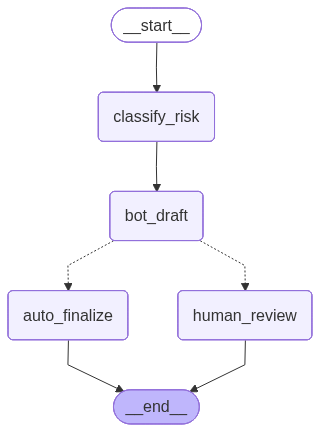

In [ ]:
Image(app.get_graph().draw_mermaid_png())

In [ ]:

# ==================== 測試案例 ====================

print("\n" + "測試 1: 低風險問題 (知識問答)")
print("="*80)
test1: HumanLoopState = {
    "user_id": "user-001",
    "text": "0050 是什麼?",
    "risk_level": "",
    "risk_reason": None,
    "needs_human": False,
    "bot_reply": None,
    "final_reply": None
}
result1 = app.invoke(test1)
print(f"\n最終回覆:\n{result1['final_reply']}")
print("="*80)

print("\n\n" + "測試 2: 高風險問題 (All in)")
print("="*80)
test2: HumanLoopState = {
    "user_id": "user-002",
    "text": "我要 all in 台積電",
    "risk_level": "",
    "risk_reason": None,
    "needs_human": False,
    "bot_reply": None,
    "final_reply": None
}
result2 = app.invoke(test2)
print(f"\n最終回覆:\n{result2['final_reply']}")
print("="*80)

print("\n\n" + "測試 3: 高風險問題 (全部賣出)")
print("="*80)
test3: HumanLoopState = {
    "user_id": "user-003",
    "text": "幫我把 2330 全部賣掉",
    "risk_level": "",
    "risk_reason": None,
    "needs_human": False,
    "bot_reply": None,
    "final_reply": None
}
result3 = app.invoke(test3)
print(f"\n最終回覆:\n{result3['final_reply']}")
print("="*80)

print("\n\n" + "測試 4: 低風險問題 (查詢持股)")
print("="*80)
test4: HumanLoopState = {
    "user_id": "user-004",
    "text": "我持有多少台積電?",
    "risk_level": "",
    "risk_reason": None,
    "needs_human": False,
    "bot_reply": None,
    "final_reply": None
}
result4 = app.invoke(test4)
print(f"\n最終回覆:\n{result4['final_reply']}")
print("="*80)

print("\n\n" + "測試 5: 高風險問題 (槓桿操作)")
print("="*80)
test5: HumanLoopState = {
    "user_id": "user-005",
    "text": "我想用融資買股票",
    "risk_level": "",
    "risk_reason": None,
    "needs_human": False,
    "bot_reply": None,
    "final_reply": None
}
result5 = app.invoke(test5)
print(f"\n📤 最終回覆:\n{result5['final_reply']}")



測試 1: 低風險問題 (知識問答)

🔍 分析風險中...
✅ 風險等級: 低風險
   原因: 使用者僅詢問『0050是什麼?』，屬於知識問答類型，未涉及交易或高風險操作。
   ➜ 可自動回覆

 AI 正在擬稿...

低風險問題 - 自動回覆 (無需人工審核)

最終回覆:
您好，0050是「元大台灣50指數股票型基金」的代號，是台灣非常受歡迎的ETF（指數股票型基金）之一。它追蹤台灣證券交易所市值最大的50家公司表現，讓投資人可以一次投資這50家公司，分散風險且操作方便。0050適合長期投資、想參與台灣整體股市成長的朋友。若您有進一步投資需求，歡迎再詢問！


測試 2: 高風險問題 (All in)

🔍 分析風險中...
⚠️  風險等級: 高風險
   原因: 使用者提及 'all in'，屬於大額交易操作，根據風險判定標準需要人工審核。
   ➜ 需要人工審核

 AI 正在擬稿...

⚠️  高風險操作檢測 - 需要人工審核

使用者問題:
我要 all in 台積電

風險原因:
使用者提及 'all in'，屬於大額交易操作，根據風險判定標準需要人工審核。

AI 擬的草稿:
感謝您對台積電的信心與看好！不過，「all in」單一股票屬於高風險操作，可能會因市場波動而影響資產安全。我們建議您在做出重大投資決策前，先與專業理財顧問討論，評估自身風險承受度及資產配置。您可透過本行APP或客服專線預約理專，獲得更完整的投資建議。

------------------------------------------------------------

請選擇:
  [1] 核准 - 直接使用 AI 草稿
  [2] 修改 - 我要修改內容
  [3] 拒絕 - 轉人工客服
請輸入 (1/2/3): 1

已核准 AI 草稿

最終回覆:
感謝您對台積電的信心與看好！不過，「all in」單一股票屬於高風險操作，可能會因市場波動而影響資產安全。我們建議您在做出重大投資決策前，先與專業理財顧問討論，評估自身風險承受度及資產配置。您可透過本行APP或客服專線預約理專，獲得更完整的投資建議。


測試 3: 高風險問題 (全部賣出)

🔍 分析風險中...
⚠️  風險等級: 高風險
   原因: 使用者指示將 2330 全部賣掉，屬於大額交易操作

測試 1: 低風險
```
問題: "0050 是什麼?"
LLM 判定: low
原因: "這是知識問答,不涉及交易操作"
流程: 自動回覆 ✅
```

測試 2: 高風險 (明顯關鍵字)
```
問題: "我要 all in 台積電"
LLM 判定: high
原因: "涉及全部資金投入單一標的,風險極高"
流程: 人工審核 ⚠️
```

測試 5: 高風險 (語意理解)
```
問題: "把所有錢都拿去買台積電好嗎?"
LLM 判定: high
原因: "雖然沒說 all in,但語意上是全部投入"
流程: 人工審核 ⚠️

## Tool-Augumented Agent

In [ ]:
from langchain.tools import tool
from typing import TypedDict, Optional, List
# ==================== 定義金融工具 ====================

@tool
def get_stock_price(symbol: str) -> str:
    """
    查詢股票最新價格和今日漲跌。

    參數:
        symbol: 股票代碼或名稱 (例如: 2330, 台積電, 0050)

    回傳:
        最新價格、漲跌幅等資訊
    """
    # 處理股票代碼
    s = symbol.strip()

    # 股票名稱轉代碼
    name_to_code = {
        "台積電": "2330.TW",
        "鴻海": "2317.TW",
        "聯發科": "2454.TW",
        "0050": "0050.TW",
        "0056": "0056.TW",
    }

    if s in name_to_code:
        s = name_to_code[s]
    elif s.isdigit():
        s = s + ".TW"

    try:
        ticker = yf.Ticker(s)
        hist = ticker.history(period='2d')

        if hist.empty:
            return f"查無 {symbol} 的資料"

        latest_price = hist['Close'].iloc[-1]
        open_price = hist['Open'].iloc[-1]
        change = latest_price - open_price
        change_pct = (change / open_price) * 100

        return f"""{symbol}({s})
最新價: {latest_price:.2f} 元
今日漲跌: {change:+.2f} 元 ({change_pct:+.2f}%)"""

    except Exception as e:
        return f"查詢失敗: {str(e)}"


@tool
def analyze_30d_ma_trend(symbol: str) -> str:
    """
    使用 30 日均線判斷目前偏多頭、偏空頭或震盪。

    參數:
        symbol: 股票代碼或名稱 (例如: 2330, 台積電)

    回傳:
        30日均線分析結果
    """
    # 處理股票代碼
    s = symbol.strip()

    name_to_code = {
        "台積電": "2330.TW",
        "鴻海": "2317.TW",
        "聯發科": "2454.TW",
        "0050": "0050.TW",
    }

    if s in name_to_code:
        s = name_to_code[s]
    elif s.isdigit():
        s = s + ".TW"

    try:
        ticker = yf.Ticker(s)
        hist = ticker.history(period="60d")

        if len(hist) < 30:
            return f"{symbol} 資料不足,無法計算 30 日均線"

        # 計算 30 日均線
        closes_30 = hist["Close"].tail(30)
        ma30 = float(closes_30.mean())
        latest = float(closes_30.iloc[-1])

        # 計算差異百分比
        diff_pct = (latest - ma30) / ma30 * 100

        # 判斷趨勢
        if diff_pct >= 2:
            trend = "偏多頭 "
            comment = "股價在均線之上,目前趨勢偏多"
        elif diff_pct <= -2:
            trend = "偏空頭 "
            comment = "股價在均線之下,目前趨勢偏空"
        else:
            trend = "震盪整理 "
            comment = "股價貼近均線,處於盤整狀態"

        return f"""{symbol}({s}) 30日均線分析:
目前價格: {latest:.2f} 元
30日均線: {ma30:.2f} 元
乖離率: {diff_pct:+.2f}%
趨勢判斷: {trend}
說明: {comment}"""

    except Exception as e:
        return f"分析失敗: {str(e)}"


@tool
def calculate_etf_yield(symbol: str) -> str:
    """
    計算 ETF 的殖利率(根據近一年配息)。

    參數:
        symbol: ETF 代碼 (例如: 0056, 00878)

    回傳:
        ETF 殖利率資訊
    """
    s = symbol.strip()

    if s.isdigit():
        s = s + ".TW"

    try:
        ticker = yf.Ticker(s)

        # 取得股息資料
        dividends = ticker.dividends

        if dividends.empty:
            return f"{symbol} 無配息資料"

        # 計算近一年配息總額
        import pandas as pd
        one_year_ago = pd.Timestamp.now() - pd.DateOffset(years=1)
        recent_dividends = dividends[dividends.index > one_year_ago]

        if recent_dividends.empty:
            return f"{symbol} 近一年無配息紀錄"

        total_dividend = recent_dividends.sum()

        # 取得目前股價
        hist = ticker.history(period='1d')
        current_price = hist['Close'].iloc[-1]

        # 計算殖利率
        dividend_yield = (total_dividend / current_price) * 100

        return f"""{symbol} 殖利率分析:
目前價格: {current_price:.2f} 元
近一年配息: {total_dividend:.2f} 元
殖利率: {dividend_yield:.2f}%"""

    except Exception as e:
        return f"計算失敗: {str(e)}"



In [ ]:

# ==================== 定義 State ====================
class ToolAgentState(TypedDict):
    user_id: str
    text: str  # 使用者問題
    tool_calls: Optional[List[str]]  # 使用了哪些工具
    tool_results: Optional[List[str]]  # 工具回傳結果
    answer: Optional[str]  # 最終回答


In [ ]:

# ==================== Node 1: 決定使用哪些工具 ====================
def plan_tools_node(state: ToolAgentState) -> ToolAgentState:
    """分析問題,決定需要使用哪些工具"""
    user_text = state["text"]

    print(f"\n📝 使用者問題: {user_text}")
    print(f"🔍 分析需要使用的工具...")

    # 使用 LLM 判斷需要哪些工具
    prompt = f"""你是金融工具規劃專家。分析使用者問題,判斷需要使用哪些工具。

可用工具:
1. get_stock_price - 查詢股票最新價格和漲跌
2. analyze_30d_ma_trend - 分析 30 日均線判斷多空
3. calculate_etf_yield - 計算 ETF 殖利率

使用者問題: {user_text}

請只回答需要的工具名稱,用逗號分隔。如果不需要工具,回答 "none"。
範例回答: "get_stock_price,analyze_30d_ma_trend" 或 "none"

回答:"""

    response = llm.invoke([{"role": "user", "content": prompt}])
    tools_needed = response.content.strip().lower()

    if tools_needed == "none":
        state["tool_calls"] = []
        print("不需要使用工具,直接回答")
    else:
        state["tool_calls"] = [t.strip() for t in tools_needed.split(",")]
        print(f"需要使用工具: {', '.join(state['tool_calls'])}")

    return state

# ==================== Node 2: 執行工具 ====================
def execute_tools_node(state: ToolAgentState) -> ToolAgentState:
    """執行工具並收集結果"""
    tool_calls = state.get("tool_calls", [])
    user_text = state["text"]

    if not tool_calls:
        state["tool_results"] = []
        return state

    print(f"\n🔧 執行工具中...")

    # 先提取股票名稱/代碼
    extract_prompt = f"""從問題中提取股票代碼或名稱。
問題: {user_text}
只回答股票代碼或名稱,例如: "2330" 或 "台積電" 或 "0056"
回答:"""

    response = llm.invoke([{"role": "user", "content": extract_prompt}])
    symbol = response.content.strip()

    print(f"   識別股票: {symbol}")

    # 執行工具
    results = []

    for tool_name in tool_calls:
        print(f"   執行 {tool_name}...")

        if tool_name == "get_stock_price":
            result = get_stock_price.invoke({"symbol": symbol})
        elif tool_name == "analyze_30d_ma_trend":
            result = analyze_30d_ma_trend.invoke({"symbol": symbol})
        elif tool_name == "calculate_etf_yield":
            result = calculate_etf_yield.invoke({"symbol": symbol})
        else:
            result = f"未知工具: {tool_name}"

        results.append(result)
        print(f"   完成")

    state["tool_results"] = results

    # 顯示工具結果
    print(f"\n工具執行結果:")
    for i, result in enumerate(results, 1):
        print(f"\n--- 工具 {i} ---")
        print(result)

    return state

# ==================== Node 3: 生成回答 ====================
def answer_node(state: ToolAgentState) -> ToolAgentState:
    """整合工具結果,生成最終回答"""
    user_text = state["text"]
    tool_results = state.get("tool_results", [])

    print(f"\n生成回答中...")

    # 準備 context
    if tool_results:
        context = "\n\n".join([f"【工具結果 {i+1}】\n{result}"
                               for i, result in enumerate(tool_results)])
    else:
        context = "無工具資料"

    # 生成回答
    system_prompt = """你是專業金融客服。根據工具提供的資料回答使用者問題。

重要規則:
1. 用白話文解釋數據
2. 適時提醒投資風險
3. 不要只是複述數據,要加上分析
4. 保持專業但親切的語氣
5. 150字內"""

    user_prompt = f"""使用者問題: {user_text}

工具提供的資料:
{context}

請根據以上資料回答使用者問題。"""

    msgs = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    response = llm.invoke(msgs)
    state["answer"] = response.content

    return state



In [ ]:
# ==================== 建立 Graph ====================
graph = StateGraph(ToolAgentState)

# 加入節點
graph.add_node("plan_tools", plan_tools_node)      # 1. 規劃工具
graph.add_node("execute_tools", execute_tools_node) # 2. 執行工具
graph.add_node("answer", answer_node)               # 3. 生成回答

# 線性流程
graph.set_entry_point("plan_tools")
graph.add_edge("plan_tools", "execute_tools")
graph.add_edge("execute_tools", "answer")
graph.add_edge("answer", END)

# 編譯
app = graph.compile()

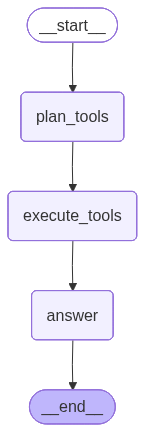

In [ ]:
Image(app.get_graph().draw_mermaid_png())



In [ ]:
print("\n" + "測試 1: 查詢股價")
print("="*80)
test1: ToolAgentState = {
    "user_id": "user-001",
    "text": "台積電現在多少錢?",
    "tool_calls": None,
    "tool_results": None,
    "answer": None
}
result1 = app.invoke(test1)
print(f"\n最終回答:\n{result1['answer']}")
print("="*80)

print("\n\n" + "測試 2: 技術分析(30日均線)")
print("="*80)
test2: ToolAgentState = {
    "user_id": "user-002",
    "text": "2330 現在是多頭還是空頭?",
    "tool_calls": None,
    "tool_results": None,
    "answer": None
}
result2 = app.invoke(test2)
print(f"\n最終回答:\n{result2['answer']}")
print("="*80)

print("\n\n" + "測試 3: ETF 殖利率")
print("="*80)
test3: ToolAgentState = {
    "user_id": "user-003",
    "text": "0056 的殖利率多少?",
    "tool_calls": None,
    "tool_results": None,
    "answer": None
}
result3 = app.invoke(test3)
print(f"\n最終回答:\n{result3['answer']}")
print("="*80)

print("\n\n" + "測試 4: 綜合分析(多個工具)")
print("="*80)
test4: ToolAgentState = {
    "user_id": "user-004",
    "text": "台積電現在價格多少?趨勢如何?",
    "tool_calls": None,
    "tool_results": None,
    "answer": None
}
result4 = app.invoke(test4)
print(f"\n最終回答:\n{result4['answer']}")
print("="*80)

print("\n\n" + "測試 5: 不需要工具(知識問答)")
print("="*80)
test5: ToolAgentState = {
    "user_id": "user-005",
    "text": "什麼是 ETF?",
    "tool_calls": None,
    "tool_results": None,
    "answer": None
}
result5 = app.invoke(test5)
print(f"\n最終回答:\n{result5['answer']}")
print("="*80)

print("\n所有測試完成!")


測試 1: 查詢股價

📝 使用者問題: 台積電現在多少錢?
🔍 分析需要使用的工具...
需要使用工具: get_stock_price

🔧 執行工具中...
   識別股票: 台積電
   執行 get_stock_price...
   完成

工具執行結果:

--- 工具 1 ---
台積電(2330.TW)
最新價: 1395.00 元
今日漲跌: -5.00 元 (-0.36%)

生成回答中...

最終回答:
台積電現在的股價是1395元，今天小跌了5元，大約下跌0.36%。雖然股價有波動，但這在股票市場是很常見的情況。投資前建議多留意相關產業消息及自身風險承受度，謹慎評估再做決定喔。


測試 2: 技術分析(30日均線)

📝 使用者問題: 2330 現在是多頭還是空頭?
🔍 分析需要使用的工具...
需要使用工具: analyze_30d_ma_trend

🔧 執行工具中...
   識別股票: 2330
   執行 analyze_30d_ma_trend...
   完成

工具執行結果:

--- 工具 1 ---
2330(2330.TW) 30日均線分析:
目前價格: 1395.00 元
30日均線: 1460.50 元
乖離率: -4.48%
趨勢判斷: 偏空頭 
說明: 股價在均線之下,目前趨勢偏空

生成回答中...

最終回答:
目前2330的股價在30日均線之下，乖離率為-4.48%，表示短期內趨勢偏空頭。這代表市場氣氛比較保守，股價有下修壓力。不過，股價走勢會受多種因素影響，提醒您投資還是要留意風險，並隨時關注基本面和消息面變化喔！


測試 3: ETF 殖利率

📝 使用者問題: 0056 的殖利率多少?
🔍 分析需要使用的工具...
需要使用工具: calculate_etf_yield

🔧 執行工具中...
   識別股票: 0056
   執行 calculate_etf_yield...
   完成

工具執行結果:

--- 工具 1 ---
計算失敗: Invalid comparison between dtype=datetime64[ns, Asia/Taipei] and Timestamp

生成回答中...

最終回答:
很抱歉，目前查詢0056的殖利率時發生資料計算上的問題，無法提供

# MCP

## FastMCP 範例

In [ ]:
%%capture
!pip install fastmcp

In [ ]:
from fastmcp import FastMCP

mcp = FastMCP("Demo 🚀")

@mcp.tool
def add(a: int, b: int) -> int:
    """加法運算"""
    return a + b

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# 建立 MCP 伺服器
from fastmcp import FastMCP

app = FastMCP("hello-server")

@app.tool
def echo(text: str) -> str:
    """回傳原文字，當作最小示範。"""
    return f"你剛剛說：{text}"

@app.tool
def add(a: int, b: int) -> int:
    """做一個簡單加法，示範可以有參數 / 回傳值。"""
    return a + b

In [ ]:
import asyncio
from fastmcp import Client

async def test_server():
    """測試 MCP 伺服器功能"""
    async with Client(app) as client:
        # 列出可用工具
        tools = await client.list_tools()
        print("可用工具:")
        for tool in tools:  # 直接遍歷 tools，不需要 .tools
            print(f"  - {tool.name}: {tool.description}")

        print("\n--- 測試 echo 工具 ---")
        result = await client.call_tool("echo", {"text": "哈囉，FastMCP！"})
        print(result.content[0].text)

        print("\n--- 測試 add 工具 ---")
        result = await client.call_tool("add", {"a": 5, "b": 3})
        print(f"5 + 3 = {result.content[0].text}")

# 執行測試
await test_server()

可用工具:
  - echo: 回傳原文字，當作最小示範。
  - add: 做一個簡單加法，示範可以有參數 / 回傳值。

--- 測試 echo 工具 ---
你剛剛說：哈囉，FastMCP！

--- 測試 add 工具 ---
5 + 3 = 8


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 建立金融分析 MCP 伺服器

In [ ]:
# 2. 建立金融分析 MCP 伺服器
from fastmcp import FastMCP
import yfinance as yf

app = FastMCP("finance-server")

def _normalize_symbol(symbol: str) -> str:
    """標準化股票代號"""
    s = symbol.strip().upper()
    if s.isdigit():
        s = s + ".TW"
    return s

@app.tool
def query_stock_price(symbol: str) -> str:
    """
    查詢股票最新價格資訊

    Args:
        symbol: 股票代號（台股可直接輸入數字，如 2330）
    """
    s = _normalize_symbol(symbol)
    ticker = yf.Ticker(s)
    hist = ticker.history(period="5d")

    if hist.empty:
        return f"找不到 {symbol} 的股價資料。"

    latest = hist.iloc[-1]
    open_price, close_price = latest[["Open", "Close"]].astype(float)
    change = close_price - open_price
    change_pct = change / open_price * 100
    date_str = latest.name.strftime("%Y-%m-%d")

    return (
        f"{s} 在 {date_str} 的收盤價約為 {close_price:.2f}，"
        f"當日漲跌 {change:+.2f}（約 {change_pct:+.2f}%）。"
    )

@app.tool
def analyze_30d_ma_trend(symbol: str) -> str:
    """
    分析股票 30 日均線趨勢

    Args:
        symbol: 股票代號（台股可直接輸入數字，如 2330）
    """
    s = _normalize_symbol(symbol)
    ticker = yf.Ticker(s)
    hist = ticker.history(period="60d")

    if len(hist) < 30:
        return f"{s} 歷史資料不足以計算 30 日均線。"

    closes_30 = hist["Close"].tail(30)
    ma30 = float(closes_30.mean())
    latest_close = float(closes_30.iloc[-1])
    diff_pct = (latest_close - ma30) / ma30 * 100

    if diff_pct >= 2:
        trend = "偏多頭（股價明顯在 30 日均線之上）"
    elif diff_pct <= -2:
        trend = "偏空頭（股價明顯在 30 日均線之下）"
    else:
        trend = "接近 30 日均線，屬於震盪或整理區間"

    return (
        f"{s} 目前收盤價約 {latest_close:.2f}，"
        f"30 日均線約 {ma30:.2f}，"
        f"相對差異約 {diff_pct:+.2f}%，判斷為：{trend}。"
        "（僅為技術指標參考，請勿單一指標做投資決策。）"
    )

In [ ]:
from fastmcp import Client

async def test_finance_server():
    """測試金融分析伺服器"""
    async with Client(app) as client:
        # 列出可用工具
        tools = await client.list_tools()
        for tool in tools:
            print(f"  • {tool.name}: {tool.description}")


        # 測試台積電股價查詢
        result = await client.call_tool("query_stock_price", {"symbol": "2330"})
        print(result.content[0].text)

        print("\n" + "="*60)

        # 測試台積電 30 日均線分析
        result = await client.call_tool("analyze_30d_ma_trend", {"symbol": "2330"})
        print(result.content[0].text)


# 執行測試
await test_finance_server()

  • query_stock_price: 查詢股票最新價格資訊

Args:
    symbol: 股票代號（台股可直接輸入數字，如 2330）
  • analyze_30d_ma_trend: 分析股票 30 日均線趨勢

Args:
    symbol: 股票代號（台股可直接輸入數字，如 2330）
2330.TW 在 2025-11-19 的收盤價約為 1395.00，當日漲跌 -5.00（約 -0.36%）。

2330.TW 目前收盤價約 1395.00，30 日均線約 1460.50，相對差異約 -4.48%，判斷為：偏空頭（股價明顯在 30 日均線之下）。（僅為技術指標參考，請勿單一指標做投資決策。）


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Resource

In [ ]:
from fastmcp import FastMCP
from fastmcp import Client
from typing import TypedDict, Optional
from typing import TypedDict, Optional, List
import os
import re
from fastmcp import Client

app = FastMCP("resource-demo")

# 靜態 Resource
@app.resource("config://version")
def get_version():
    """取得系統版本資訊"""
    return "v2.0.1"

# 動態 Resource Template（使用 URI 參數）
@app.resource("users://{user_id}/profile")
def get_user_profile(user_id: int):
    """取得使用者個人資料"""
    # 模擬資料庫查詢
    users_db = {
        1: {"name": "張三", "level": "VIP", "balance": 50000},
        2: {"name": "李四", "level": "一般", "balance": 10000},
    }

    user = users_db.get(user_id)
    if not user:
        return f"找不到使用者 {user_id}"

    return f"""餘額: NT$ {user['balance']:,}"""

In [ ]:
async def test_resources():
    async with Client(app) as client:
        # 列出所有 resources
        resources = await client.list_resources()
        print("可用的 Resources:")
        for r in resources:
            print(f"  • {r.uri}")

        # 讀取靜態 resource
        version = await client.read_resource("config://version")
        print(f"\n版本: {version[0].text}")

        # 讀取動態 resource
        profile = await client.read_resource("users://1/profile")
        print(f"\n{profile[0].text}")

await test_resources()

可用的 Resources:
  • config://version

版本: v2.0.1

餘額: NT$ 50,000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Prompt

In [ ]:
from fastmcp import FastMCP
from fastmcp.prompts import Message

app = FastMCP("prompt-demo")

# 簡單的 Prompt（回傳字串）
@app.prompt
def financial_analysis_template(symbol: str) -> str:
    """生成股票分析提示"""
    return f"""請分析 {symbol} 這支股票，包含：
    1. 基本面分析
    2. 技術面分析
    3. 風險評估
    4. 投資建議

請保持客觀，並註明風險。"""

# 進階 Prompt（回傳 Message 物件）
@app.prompt
def risk_assessment_chat(investment_amount: int, risk_tolerance: str) -> list:
    """生成風險評估對話"""
    return [
        Message(
            role="system",
            content="""你是專業的理財顧問，專門協助客戶評估投資風險。
你會根據客戶的資金和風險承受度，提供適合的投資建議。"""
        ),
        Message(
            role="user",
            content=f"""我有 NT$ {investment_amount:,} 元想投資，
我的風險承受度是：{risk_tolerance}
請給我投資建議。"""
        )
    ]

# 多輪對話 Prompt
@app.prompt
def portfolio_review(stocks: str) -> list:
    """投資組合健檢提示"""
    return [
        Message(role="system", content="你是投資組合分析師"),
        Message(role="user", content=f"我的持股：{stocks}"),
        Message(role="assistant", content="我會為您分析持股結構"),
        Message(role="user", content="請評估風險並給建議")
    ]



In [ ]:
# 測試 Prompts
async def test_prompts():
    async with Client(app) as client:
        # 列出所有 prompts
        prompts = await client.list_prompts()
        print("可用的 Prompts:")
        for p in prompts:
            print(f"  • {p.name}: {p.description}")

        # 取得 prompt
        result = await client.get_prompt(
            "financial_analysis_template",
            {"symbol": "2330"}
        )
        print(f"\n生成的提示:\n{result.messages[0].content.text}")

await test_prompts()

可用的 Prompts:
  • financial_analysis_template: 生成股票分析提示
  • risk_assessment_chat: 生成風險評估對話
  • portfolio_review: 投資組合健檢提示

生成的提示:
請分析 2330 這支股票，包含：
    1. 基本面分析
    2. 技術面分析
    3. 風險評估
    4. 投資建議

請保持客觀，並註明風險。


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Context

In [91]:
from fastmcp import FastMCP, Context
import asyncio

app = FastMCP("context-demo")  # 不需要 llm 參數

@app.tool
async def analyze_stock_with_context(symbol: str, ctx: Context) -> str:
    """使用 Context 進行完整的股票分析"""

    await ctx.info(f"開始分析 {symbol}...")
    await ctx.report_progress(0, 100, "初始化分析")

    await asyncio.sleep(0.5)
    await ctx.report_progress(30, 100, "取得市場資料")

    # 讀取 Resource
    try:
        market_data = await ctx.read_resource("market://summary")
        market_info = market_data.content[0].text
        await ctx.info("已取得市場資料")
    except:
        market_info = "市場資料暫時無法取得"
        await ctx.warning("無法取得市場資料")

    await ctx.report_progress(60, 100, "分析技術指標")
    await ctx.info("請求 LLM 進行分析...")

    analysis_prompt = f"""請分析 {symbol} 的投資價值。

市場背景:
{market_info}

請提供：
1. 短評（50字內）
2. 風險等級（低/中/高）
3. 是否適合新手投資者"""

    try:
        # 直接調用之前定義的 llm 對象，而非 ctx.sample()
        llm_response = await llm.ainvoke(analysis_prompt)
        analysis = llm_response.content
    except Exception as e:
        await ctx.error(f"LLM 分析失敗: {str(e)}")
        analysis = "分析暫時無法完成"

    await ctx.report_progress(100, 100, "分析完成")
    await ctx.info("分析完成")

    return f"""{symbol} 分析報告
{analysis}
---
分析時間: 2025-11-16
資料來源: 市場即時資訊"""

In [92]:
# 測試 Context 功能
async def test_context():
    async with Client(app) as client:
        result = await client.call_tool(
            "analyze_stock_with_context",
            {"symbol": "2330"}
        )
        print(result.content[0].text)

await test_context()

[11/19/25 16:45:47] DEBUG    Sending INFO to client: 開始分析 2330...                                ]8;id=152676;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=298345;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '開始分析 2330...', 'extra': None}    ]8;id=348160;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=417722;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

                    DEBUG    Sending WARNING to client: 無法取得市場資料                             ]8;id=842614;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=723831;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    WARNING  Received WARNING from server: {'msg': '無法取得市場資料', 'extra': None} ]8;id=513417;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=576169;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

                    DEBUG    Sending INFO to client: 請求 LLM 進行分析...                            ]8;id=713964;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=797784;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '請求 LLM 進行分析...', 'extra':      ]8;id=836630;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=785714;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\
                             None}                                                                                 

[11/19/25 16:45:50] DEBUG    Sending INFO to client: 分析完成                                        ]8;id=84380;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=925349;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '分析完成', 'extra': None}            ]8;id=216555;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=362564;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

2330 分析報告
1. 短評：  
台積電（2330）為全球先進晶圓代工龍頭，長期成長性佳，具產業護城河。

2. 風險等級：  
中

3. 是否適合新手投資者：  
適合。基本面穩健，波動相對同業較低，長期持有具吸引力。
---
分析時間: 2025-11-16
資料來源: 市場即時資訊


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Authentication (JWT)

In [93]:
from fastmcp import FastMCP, Context
from fastmcp import Client

from fastmcp.server.auth.providers.jwt import JWTVerifier

auth = JWTVerifier(
    jwks_uri="https://your-auth-system.com/.well-known/jwks.json",
    issuer="https://your-auth-system.com",
    audience="mcp-server"
)

@app.tool
async def get_stock_price(symbol: str, ctx: Context) -> str:
    """查詢股價 - 需要有效 JWT token"""
    await ctx.info(f"已驗證用戶查詢 {symbol}")
    return f"💰 {symbol} 價格: 1050 元"

## Authorization

In [101]:
from fastmcp import FastMCP, Context
from fastmcp import Client

# ============================================================
# 用戶資料庫
# ============================================================
USERS_DB = {
    "sk_basic_001": {"name": "張三", "role": "basic"},
    "sk_premium_002": {"name": "李四", "role": "premium"},
    "sk_admin_003": {"name": "管理員", "role": "admin"}
}

ROLE_LEVELS = {"basic": 1, "premium": 2, "admin": 3}

# ============================================================
# 建立 MCP Server（不使用內建 auth）
# ============================================================
app = FastMCP("auth-demo")

def check_permission(api_key: str, required_role: str) -> tuple[bool, dict]:
    """檢查 API key 的權限等級"""
    user = USERS_DB.get(api_key)
    if not user:
        return False, {}

    user_level = ROLE_LEVELS.get(user["role"], 0)
    required_level = ROLE_LEVELS.get(required_role, 0)

    return user_level >= required_level, user

# ============================================================
# 定義需要不同權限的工具
# ============================================================

@app.tool
async def get_stock_price(symbol: str, api_key: str, ctx: Context) -> str:
    """查詢股價 - 所有用戶可用（需要 basic）"""
    has_perm, user = check_permission(api_key, "basic")

    if not has_perm:
        await ctx.error("認證失敗")
        return "無效的 API Key"

    await ctx.info(f"{user['name']} 查詢 {symbol}")
    return f"""{symbol} 股價資訊

價格: 1050 元
漲跌: +15 (+1.45%)

查詢者: {user['name']}
會員等級: {user['role'].upper()}"""

@app.tool
async def get_advanced_analysis(symbol: str, api_key: str, ctx: Context) -> str:
    """進階分析 - Premium 以上可用"""
    has_perm, user = check_permission(api_key, "premium")

    if not has_perm:
        # 檢查是否是有效用戶但權限不足
        valid_user = USERS_DB.get(api_key)
        if valid_user:
            await ctx.warning(f"{valid_user['name']} 權限不足")
            return f"""權限不足

您的會員: {valid_user['name']} ({valid_user['role']})
需要等級: Premium 或 Admin

請升級會員以使用進階分析功能。"""
        else:
            await ctx.error("認證失敗")
            return "無效的 API Key"

    await ctx.info(f"{user['name']} 執行進階分析")
    return f"""{symbol} 進階分析報告

技術指標:
- RSI: 65 (偏多)
- MACD: 正向交叉
- 布林通道: 接近上軌

基本面:
- 本益比: 30
- 股息率: 2.5%
- EPS 成長: +15% YoY

Premium 會員專屬
分析師: {user['name']}"""

@app.tool
async def export_data(api_key: str, ctx: Context) -> str:
    """資料匯出 - 僅限 Admin"""
    has_perm, user = check_permission(api_key, "admin")

    if not has_perm:
        valid_user = USERS_DB.get(api_key)
        if valid_user:
            await ctx.error(f"{valid_user['name']} 嘗試執行管理員功能")
            return f"""禁止訪問

您的會員: {valid_user['name']} ({valid_user['role']})
此功能僅限: Admin

此操作已被記錄。"""
        else:
            await ctx.error("認證失敗")
            return "無效的 API Key"

    await ctx.warning(f"{user['name']} 執行敏感操作：資料匯出")
    return f"""系統資料匯出完成

匯出內容:
✓ 用戶資料 (125 筆)
✓ 交易記錄 (5,430 筆)
✓ 系統日誌 (10,250 筆)

執行者: {user['name']}
時間: 2025-11-16
🔒 管理員專用功能"""


In [102]:

# ============================================================
# 測試不同權限等級
# ============================================================

async def test_authorization():
    test_cases = [
        ("Basic 用戶", "sk_basic_001"),
        ("Premium 用戶", "sk_premium_002"),
        ("Admin 用戶", "sk_admin_003"),
        ("無效 Key", "invalid_key_999"),
    ]

    for label, api_key in test_cases:
        print(f"\n{'='*70}")
        print(f"測試: {label}")
        print('='*70)

        async with Client(app) as client:
            # 測試 1: 查價格
            print("\n查詢股價")
            result = await client.call_tool("get_stock_price", {
                "symbol": "2330",
                "api_key": api_key
            })
            print(result.content[0].text)

            # 測試 2: 進階分析
            print("\n進階分析")
            result = await client.call_tool("get_advanced_analysis", {
                "symbol": "2330",
                "api_key": api_key
            })
            print(result.content[0].text)

            # 測試 3: 匯出資料
            print("\n匯出資料")
            result = await client.call_tool("export_data", {
                "api_key": api_key
            })
            print(result.content[0].text)
            print()

await test_authorization()



測試: Basic 用戶

查詢股價


[11/19/25 16:49:48] DEBUG    Sending INFO to client: 張三 查詢 2330                                  ]8;id=497919;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=76028;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '張三 查詢 2330', 'extra': None}      ]8;id=391071;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=821968;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

2330 股價資訊

價格: 1050 元
漲跌: +15 (+1.45%)

查詢者: 張三
會員等級: BASIC

進階分析


                    DEBUG    Sending WARNING to client: 張三 權限不足                                ]8;id=943968;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=56219;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    WARNING  Received WARNING from server: {'msg': '張三 權限不足', 'extra': None}    ]8;id=535532;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=965406;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

權限不足

您的會員: 張三 (basic)
需要等級: Premium 或 Admin

請升級會員以使用進階分析功能。

匯出資料


                    DEBUG    Sending ERROR to client: 張三 嘗試執行管理員功能                        ]8;id=267865;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=615064;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    ERROR    Received ERROR from server: {'msg': '張三 嘗試執行管理員功能', 'extra':  ]8;id=166540;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=632676;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\
                             None}                                                                                 

禁止訪問

您的會員: 張三 (basic)
此功能僅限: Admin

此操作已被記錄。


測試: Premium 用戶

查詢股價


                    DEBUG    Sending INFO to client: 李四 查詢 2330                                  ]8;id=35792;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=984820;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '李四 查詢 2330', 'extra': None}      ]8;id=119769;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=441388;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

2330 股價資訊

價格: 1050 元
漲跌: +15 (+1.45%)

查詢者: 李四
會員等級: PREMIUM

進階分析


                    DEBUG    Sending INFO to client: 李四 執行進階分析                               ]8;id=292439;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=376258;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '李四 執行進階分析', 'extra': None}   ]8;id=29010;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=735478;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

2330 進階分析報告 

技術指標:
- RSI: 65 (偏多)
- MACD: 正向交叉
- 布林通道: 接近上軌

基本面:
- 本益比: 30
- 股息率: 2.5%
- EPS 成長: +15% YoY

Premium 會員專屬
分析師: 李四

匯出資料


                    DEBUG    Sending ERROR to client: 李四 嘗試執行管理員功能                        ]8;id=714741;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=163008;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    ERROR    Received ERROR from server: {'msg': '李四 嘗試執行管理員功能', 'extra':  ]8;id=400874;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=627211;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\
                             None}                                                                                 

禁止訪問

您的會員: 李四 (premium)
此功能僅限: Admin

此操作已被記錄。


測試: Admin 用戶

查詢股價


                    DEBUG    Sending INFO to client: 管理員 查詢 2330                                ]8;id=750056;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=89448;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '管理員 查詢 2330', 'extra': None}    ]8;id=562390;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=609596;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

2330 股價資訊

價格: 1050 元
漲跌: +15 (+1.45%)

查詢者: 管理員
會員等級: ADMIN

進階分析


                    DEBUG    Sending INFO to client: 管理員 執行進階分析                             ]8;id=863444;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=527339;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '管理員 執行進階分析', 'extra': None} ]8;id=483440;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=643560;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

2330 進階分析報告 

技術指標:
- RSI: 65 (偏多)
- MACD: 正向交叉
- 布林通道: 接近上軌

基本面:
- 本益比: 30
- 股息率: 2.5%
- EPS 成長: +15% YoY

Premium 會員專屬
分析師: 管理員

匯出資料


                    DEBUG    Sending WARNING to client: 管理員 執行敏感操作：資料匯出                ]8;id=527167;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=904857;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    WARNING  Received WARNING from server: {'msg': '管理員 執行敏感操作：資料匯出',   ]8;id=124347;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=525988;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\
                             'extra': None}                                                                        

系統資料匯出完成

匯出內容:
✓ 用戶資料 (125 筆)
✓ 交易記錄 (5,430 筆)
✓ 系統日誌 (10,250 筆)

執行者: 管理員
時間: 2025-11-16
🔒 管理員專用功能


測試: 無效 Key

查詢股價


                    DEBUG    Sending ERROR to client: 認證失敗                                       ]8;id=287315;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=110723;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    ERROR    Received ERROR from server: {'msg': '認證失敗', 'extra': None}           ]8;id=433430;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=610637;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

無效的 API Key

進階分析


                    DEBUG    Sending ERROR to client: 認證失敗                                       ]8;id=520305;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=340209;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    ERROR    Received ERROR from server: {'msg': '認證失敗', 'extra': None}           ]8;id=781519;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=67079;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

無效的 API Key

匯出資料


                    DEBUG    Sending ERROR to client: 認證失敗                                       ]8;id=421975;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=116168;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    ERROR    Received ERROR from server: {'msg': '認證失敗', 'extra': None}           ]8;id=879628;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=353603;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

無效的 API Key



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 金融服務 MCP Server

In [106]:
from fastmcp import FastMCP, Context
from fastmcp.prompts import Message
from fastmcp import Client

# ============================================================
# 金融服務 MCP Server - 整合範例
# ============================================================

app = FastMCP("financial-service")

# --- Resource: 唯讀資料 ---
@app.resource("market://status")
def market_status():
    """市場狀態"""
    return "開盤中 | 加權指數 18,500 (+1.2%)"

@app.resource("news://tech")
def tech_news():
    """科技股新聞"""
    return "台積電宣布 2nm 製程進展 | AI 晶片需求強勁"

# --- Prompt: 提示模板 ---
@app.prompt
def investment_advice(risk_level: str) -> list:
    """投資建議提示"""
    return [
        Message(role="user", content=f"我的風險等級是 {risk_level}，作為理財顧問請給我投資建議")
    ]

# --- Tool: 功能（展示 Context 用法）---
@app.tool
async def analyze_stock(symbol: str, ctx: Context) -> str:
    """
    股票分析 - 整合 Resource、Progress
    """
    await ctx.info(f"開始分析 {symbol}")
    await ctx.report_progress(0, 100, "初始化")

    # 讀取 Resource（在 Context 中用 .content）
    market = await ctx.read_resource("market://status")
    market_info = market[0].content

    await ctx.report_progress(50, 100, "讀取新聞")

    # 讀取科技新聞
    news = await ctx.read_resource("news://tech")
    news_info = news[0].content
    await ctx.report_progress(100, 100, "完成")
    await ctx.info("分析完成")

    return f"""{symbol} 分析報告

市場狀態：
{market_info}

相關新聞：
{news_info}

技術分析：
- 股價位置：相對高檔
- 趨勢：偏多
- 建議：適合長期持有

此為範例資料，非真實分析"""

@app.tool
async def quick_check(symbol: str, ctx: Context) -> str:
    """快速查詢"""
    return f"⚡ {symbol} 快速查詢\n價格: 1050 元 | 漲跌: +1.5%"



In [107]:
# ============================================================
# 測試
# ============================================================

async def demo():
    async with Client(app) as client:
        # 1. Resources
        market = await client.read_resource("market://status")
        print(f"市場: {market[0].text}")

        news = await client.read_resource("news://tech")
        print(f"新聞: {news[0].text}\n")

        # 2. Prompts
        prompt = await client.get_prompt("investment_advice", {"risk_level": "中等"})
        print(f"提示: {prompt.messages[0].content.text}\n")

        # 3. Tools
        result = await client.call_tool("quick_check", {"symbol": "2330"})
        print(f"快速查詢:\n{result.content[0].text}\n")

        # 完整分析（含 Context 功能）
        result = await client.call_tool("analyze_stock", {"symbol": "2330"})
        print(f"完整分析:\n{result.content[0].text}\n")


await demo()

市場: 開盤中 | 加權指數 18,500 (+1.2%)
新聞: 台積電宣布 2nm 製程進展 | AI 晶片需求強勁

提示: 我的風險等級是 中等，作為理財顧問請給我投資建議

快速查詢:
⚡ 2330 快速查詢
價格: 1050 元 | 漲跌: +1.5%



[11/19/25 16:51:34] DEBUG    Sending INFO to client: 開始分析 2330                                   ]8;id=307206;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=802098;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '開始分析 2330', 'extra': None}       ]8;id=903276;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=71036;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

                    DEBUG    Sending INFO to client: 分析完成                                        ]8;id=548414;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py\context.py]8;;\:]8;id=197285;file:///usr/local/lib/python3.12/dist-packages/fastmcp/server/context.py#792\792]8;;\

                    INFO     Received INFO from server: {'msg': '分析完成', 'extra': None}            ]8;id=949407;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py\logging.py]8;;\:]8;id=566055;file:///usr/local/lib/python3.12/dist-packages/fastmcp/client/logging.py#44\44]8;;\

完整分析:
2330 分析報告

市場狀態：
開盤中 | 加權指數 18,500 (+1.2%)

相關新聞：
台積電宣布 2nm 製程進展 | AI 晶片需求強勁

技術分析：
- 股價位置：相對高檔
- 趨勢：偏多
- 建議：適合長期持有

此為範例資料，非真實分析



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
